In [77]:
!pip install fastbook

In [78]:
import fastbook
fastbook.setup_book()

In [79]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG

In [81]:
import pandas as pd
from pathlib import Path

test_df = pd.read_csv(Path('/kaggle/input/playground-series-s4e8/test.csv'))
train_df = pd.read_csv(Path('/kaggle/input/playground-series-s4e8/train.csv'))
sample_df = pd.read_csv(Path('/kaggle/input/playground-series-s4e8/sample_submission.csv'))

In [82]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
# train_df.drop(['gill-spacing','cap-surface','gill-attachment','stem-root',
#          'stem-surface','veil-type','veil-color','spore-print-color'], inplace = True, axis =1)

In [ ]:
# test_df.drop(['gill-spacing','cap-surface','gill-attachment','stem-root',
#          'stem-surface','veil-type','veil-color','spore-print-color'], inplace = True, axis =1)

In [ ]:
# # Function to check the number of rows before and after applying a filter
# def filter_summary(df, column):
#     value_counts = df[column].value_counts()
#     value_keep = value_counts[value_counts>9].index
#     df_filtered = df[df[column].isin(value_keep)]
#     return df_filtered

# # Apply filters and summarize the impact
# train_df = filter_summary(train_df, 'cap-shape')
# train_df = filter_summary(train_df, 'cap-surface')
# train_df = filter_summary(train_df, 'cap-color')
# train_df = filter_summary(train_df, 'does-bruise-or-bleed')
# train_df = filter_summary(train_df, 'gill-attachment')
# train_df = filter_summary(train_df, 'gill-spacing')
# train_df = filter_summary(train_df, 'gill-color')
# train_df = filter_summary(train_df, 'stem-root')
# train_df = filter_summary(train_df, 'stem-surface')
# train_df = filter_summary(train_df, 'stem-color')
# train_df = filter_summary(train_df, 'has-ring')

In [ ]:
len(train_df), len(test_df)

In [ ]:
train_df.head()

In [ ]:
len(train_df)

In [83]:
train_size = int(0.8 * len(train_df))
train_idx = list(range(train_size))
valid_idx = list(range(train_size, len(train_df)))

splits = (list(train_idx),list(valid_idx))

In [84]:
depVar = 'class'
train_df[depVar] = train_df[depVar].astype('category')
procs = [Categorify, FillMissing]
# FillMissing is just:
# df_train = df_train.fillna(df_train.mean())
continuous, categorical = cont_cat_split(train_df, 1, dep_var=depVar)
to = TabularPandas(train_df, procs, categorical, continuous, y_names=depVar, splits=splits)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [ ]:
len(to.train), len(to.valid)

In [86]:
def rmse(prediction, label):
    return round(math.sqrt(((prediction-label)**2).mean()), 6)
def m_rmse(model, xs, y):
    return rmse(model.predict(xs), y)

In [87]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
valid_xs.shape, valid_y.shape

((623389, 22), (623389,))

In [88]:
def randomForestFunction(xs, y, n_estimators, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [89]:
randomForest = randomForestFunction(xs, y, 40)

In [90]:
m_rmse(randomForest, xs, y), m_rmse(randomForest, valid_xs, valid_y)

(0.094989, 0.096116)

In [91]:
[estimator.get_n_leaves() for estimator in randomForest.estimators_]

[3213,
 3242,
 3228,
 3335,
 3253,
 3193,
 3300,
 3092,
 3307,
 3139,
 3150,
 3269,
 3157,
 3136,
 3098,
 3189,
 3201,
 3248,
 3150,
 3140,
 3320,
 3180,
 3200,
 3332,
 3040,
 3253,
 3059,
 3398,
 3164,
 3197,
 3111,
 3212,
 3135,
 3090,
 3397,
 3232,
 3314,
 3297,
 3343,
 3242]

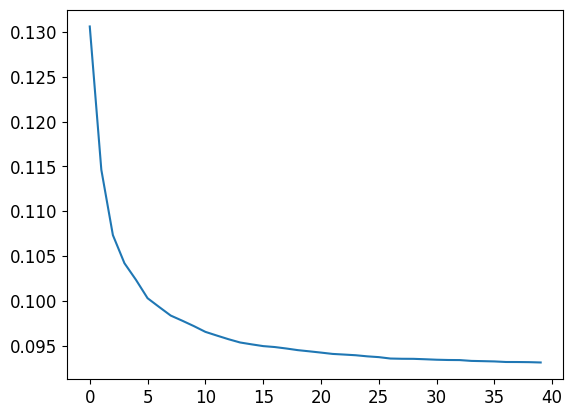

In [92]:
valid_xs_np = valid_xs.to_numpy()
preds = np.stack([estimator.predict(valid_xs_np) for estimator in randomForest.estimators_])
rmse(preds.mean(0), valid_y), plt.plot([rmse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [93]:
if train_df.columns.all() == test_df.columns.all():
    print('True')

True


In [94]:
# Reprocess test_df with the same pipeline
to_test = TabularPandas(test_df, procs, categorical, continuous)
test_xs = to_test.xs
test_xs = test_xs[xs.columns]

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [95]:
# Make predictions
predictions = randomForest.predict(test_xs)

# Create a new list with modified predictions
modified_predictions = ['p' if pred == 1 else 'e' for pred in predictions]

In [96]:
ids = test_xs['id'].to_list()
submission_csv = pd.DataFrame({
    'id': ids,
    'class': modified_predictions
})

In [97]:
submission_csv.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [98]:
submission_csv.to_csv('submission4.csv', index=False)